In [1]:
%pip install tensorflow matplotlib scikit-learn pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2022-12-27 08:46:55.450776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 08:46:55.643917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-27 08:46:55.643958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-27 08:46:56.554146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

SystemError: GPU device not found

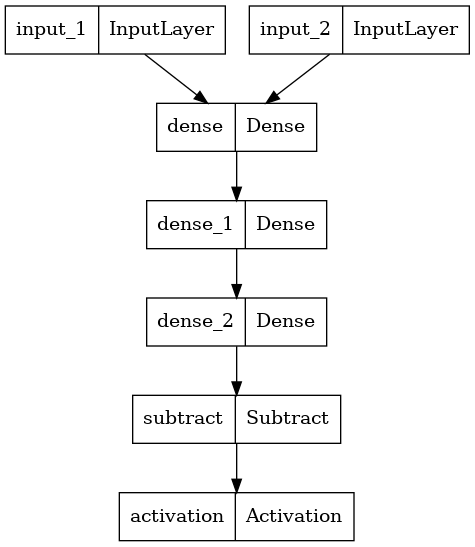

In [3]:

import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

with tf.device('/device:GPU:0'):
  # model architecture
  class RankNet(Model):
      def __init__(self):
          super().__init__()
          self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
          self.o = layers.Dense(1, activation='linear')
          self.oi_minus_oj = layers.Subtract()
      
      def call(self, inputs):
          xi, xj = inputs
          densei = self.dense[0](xi)
          densej = self.dense[0](xj)
          for dense in self.dense[1:]:
              densei = dense(densei)
              densej = dense(densej)
          oi = self.o(densei)
          oj= self.o(densej)
          oij = self.oi_minus_oj([oi, oj])
          output = layers.Activation('sigmoid')(oij)
          return output
      
      def build_graph(self):
          x = [Input(shape=(10)), Input(shape=(10))]
          return Model(inputs=x, outputs=self.call(x))

# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

In [6]:
from os import listdir
from os.path import isfile, join
def getJudgmentsBatchFileByFile():
    """
    Returns a generator function that returns all the judgment batches files from the directory
    """
    files = []
   
    files = [join('./loggedFeatures', file) for file in listdir('./loggedFeatures') if isfile(join('./loggedFeatures', file))]
    for file in files:
        yield file

In [7]:
import csv
judgments = []
for file in getJudgmentsBatchFileByFile():
  with open(file,'r') as f:
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
      data = []
      for element in row:
        data.append(element.replace(',', ''))
      judgments.append(data)

In [8]:
judgments.sort(key = lambda judgments: judgments[1])
print(judgments[0])
print(judgments[1])
print(judgments[2])
print(judgments[3])

['1', '10000', 'msmarco_doc_10_1691063043', '1.0', '8.0', '9.0', '9.0', '0.083333336', '0.6666667', '0.75', '0.75', '1.0', '11.69213', '55.452248', '57.059895', '90.48286', '71.1965', '38.33255', '38.325306', '8.277235', '63.746307', '139.44073', '144.08391', '3.3537564', '6.161056', '2.6165454', '2.5894945']
['0', '10000', 'msmarco_doc_05_72507775', '1.0', '2.0', '8.0', '8.0', '0.083333336', '0.16666667', '0.6666667', '0.6666667', '1.0', '2.4142137', '36.53677', '36.764153', '90.48286', '71.1965', '38.33255', '38.325306', '6.947685', '9.943436', '76.099815', '76.71629', '1.4357138', '0.64040625', '0.65897375', '0.6643161']
['0', '1000005', 'msmarco_doc_10_1691063043', '0.0', '0.0', '1.0', '1.0', '0.0', '0.0', '0.25', '0.25', '0.0', '0.0', '4.1231055', '4.1231055', '26.600231', '22.689518', '12.23183', '12.228702', '0.0', '0.0', '4.340817', '4.338505', '0.0', '0.0', '0.08145297', '0.077972166']
['1', '1000005', 'msmarco_doc_05_72507775', '2.0', '2.0', '3.0', '3.0', '0.5', '0.5', '0.75'

In [9]:
for j in judgments:
  del j[2]

print(judgments[0])
print(judgments[1])
print(judgments[2])
print(judgments[3])
print(judgments[4])
print(judgments[5])
print(judgments[6])
print(judgments[7])

['1', '10000', '1.0', '8.0', '9.0', '9.0', '0.083333336', '0.6666667', '0.75', '0.75', '1.0', '11.69213', '55.452248', '57.059895', '90.48286', '71.1965', '38.33255', '38.325306', '8.277235', '63.746307', '139.44073', '144.08391', '3.3537564', '6.161056', '2.6165454', '2.5894945']
['0', '10000', '1.0', '2.0', '8.0', '8.0', '0.083333336', '0.16666667', '0.6666667', '0.6666667', '1.0', '2.4142137', '36.53677', '36.764153', '90.48286', '71.1965', '38.33255', '38.325306', '6.947685', '9.943436', '76.099815', '76.71629', '1.4357138', '0.64040625', '0.65897375', '0.6643161']
['0', '1000005', '0.0', '0.0', '1.0', '1.0', '0.0', '0.0', '0.25', '0.25', '0.0', '0.0', '4.1231055', '4.1231055', '26.600231', '22.689518', '12.23183', '12.228702', '0.0', '0.0', '4.340817', '4.338505', '0.0', '0.0', '0.08145297', '0.077972166']
['1', '1000005', '2.0', '2.0', '3.0', '3.0', '0.5', '0.5', '0.75', '0.75', '2.0', '7.8929224', '22.769188', '24.606716', '26.600231', '22.689518', '12.23183', '12.228702', '16.6

In [10]:
#create pairs
xi = []
xj = []
pij = []
judgmentPairs = []

for i in range(1, len(judgments), 2):
  judgmentPairs.append([judgments[i - 1], judgments[i]])
  xi.append(judgments[i - 1][2:])
  xj.append(judgments[i][2:])
  if judgments[i-1][0] == judgments[i][0]:
    _pij = 0.5
  elif judgments[i-1][0] > judgments[i][0]:
    _pij = 1
  else: 
    _pij = 0
  pij.append(_pij)

In [11]:
xi = np.array(xi, dtype='float64')

In [12]:
xj = np.array(xj, dtype='float64')

In [13]:
pij = np.array(pij, dtype='float64')

In [14]:
from sklearn.model_selection import train_test_split

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test = train_test_split(
    xi, xj, pij, test_size=0.2, shuffle=False)

In [17]:
# train model using compile and fit
with tf.device('/device:GPU:0'):
  ranknet = RankNet()
  ranknet.compile(optimizer='adam', loss='binary_crossentropy')
  history = ranknet.fit([xi_train, xj_train], pij_train, epochs=100, batch_size=1, validation_data=([xi_test, xj_test], pij_test))


Epoch 1/100
  8237/265553 [..............................] - ETA: 13:18 - loss: 0.2221

KeyboardInterrupt: 

In [16]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=0.2)

NameError: name 'history' is not defined